# Completion profiling

Profiling avec cProfile, memory_profiler, line_profiler, pyinstrument, snakeviz.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Setup

### Function to profile

In [3]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
               for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0])
                for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

### Data

In [4]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [5]:
len(file_titles)

33

In [6]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [7]:
import random
sample1000 = random.sample(list_titles, 1000)
with open("sample1000.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(sample1000))

## Standard modules

### cProfile

In [8]:
import cProfile, io, pstats, os

def toprofile0(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))

def doprofile(lines, filename):
    pr = cProfile.Profile()
    pr.enable()
    toprofile0(lines)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
    res = s.getvalue().replace(rem, "")
    ps.dump_stats(filename)
    return res

In [9]:
r = doprofile(sample1000, "completion.prof")
print(r)

         1225828 function calls in 1.261 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.261    1.261 <ipython-input-8-d2b6d910fdd7>:3(toprofile0)
        1    0.000    0.000    1.261    1.261 <ipython-input-3-684f3e860cf5>:3(gain_dynamique_moyen_par_mot)
        1    0.129    0.129    0.916    0.916 \src\mlstatpy\nlp\completion.py:416(precompute_stat)
    15148    0.260    0.000    0.662    0.000 \src\mlstatpy\nlp\completion.py:504(merge_completions)
    15148    0.277    0.000    0.281    0.000 {built-in method builtins.__build_class__}
        1    0.051    0.051    0.216    0.216 \src\mlstatpy\nlp\completion.py:451(update_stat_dynamic)
        1    0.087    0.087    0.107    0.107 \src\mlstatpy\nlp\completion.py:203(build)
    16147    0.048    0.000    0.090    0.000 \src\mlstatpy\nlp\completion.py:556(update_dynamic_minimum_keystroke)
    34403    0.061    0.000    0.070    0.000 \sr

## Others informations when profiling

### memory_profiler

See [memory_profiler](https://pypi.python.org/pypi/memory_profiler/0.41).

In [10]:
from memory_profiler import profile
%load_ext memory_profiler

In [11]:
%memit toprofile0(sample1000)

peak memory: 412.05 MiB, increment: 15.60 MiB


In [12]:
from io import StringIO
st = StringIO()
@profile(stream=st)
def toprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))
toprofile(sample1000)

ERROR: Could not find file <ipython-input-12-7512ff5cdee3>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.


In [13]:
%%file temp_mem_profile.py

from mlstatpy.nlp.completion import CompletionTrieNode
from memory_profiler import profile

@profile(precision=4)
def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
               for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0])
                for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

@profile(precision=4)
def toprofile():
    with open("sample1000.txt", "r", encoding="utf-8") as f:
        lines = [_.strip("\n\r ") for _ in f.readlines()]
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))
toprofile()

Overwriting temp_mem_profile.py


In [14]:
import sys
cmd = sys.executable
from pyquickhelper.loghelper import run_cmd
cmd += " -m memory_profiler temp_mem_profile.py"
out, err = run_cmd(cmd, wait=True)
print(out)

Filename: temp_mem_profile.py

Line #    Mem usage    Increment   Line Contents
     5  56.0625 MiB  56.0625 MiB   @profile(precision=4)
     6                             def gain_dynamique_moyen_par_mot(queries, weights):
     7  56.0625 MiB   0.0000 MiB       per = list(zip(weights, queries))
     8  56.0625 MiB   0.0000 MiB       total = sum(weights) * 1.0
     9  56.0625 MiB   0.0000 MiB       res = []
    10  62.2500 MiB   6.1875 MiB       trie = CompletionTrieNode.build([(None, q) for _, q in per])
    11  69.5625 MiB   7.3125 MiB       trie.precompute_stat()
    12  78.7695 MiB   9.2070 MiB       trie.update_stat_dynamic()
    13  78.7734 MiB   0.0039 MiB       wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    14  78.7969 MiB   0.0234 MiB       wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
    15  78.7969 MiB   0.0000 MiB                  for p, w in per]
    16  78.7969 MiB   0.0000 MiB       wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keys

### line_profiler

See [line_profiler](https://github.com/rkern/line_profiler).

In [15]:
def lineprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))

In [16]:
from mlstatpy.nlp.completion import CompletionTrieNode

In [17]:
from line_profiler import LineProfiler
prof = LineProfiler()
prof.add_function(gain_dynamique_moyen_par_mot)
prof.add_function(CompletionTrieNode.precompute_stat)
prof.run("lineprofile(sample1000)")
st = io.StringIO()
prof.print_stats(stream=st)
rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
res = st.getvalue().replace(rem, "")
print(res)

Timer unit: 3.95062e-07 s

Total time: 3.3536 s
File: <ipython-input-3-684f3e860cf5>
Function: gain_dynamique_moyen_par_mot at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def gain_dynamique_moyen_par_mot(queries, weights):
     4         1        393.0    393.0      0.0      per = list(zip(weights, queries))
     5         1         23.0     23.0      0.0      total = sum(weights) * 1.0
     6         1          4.0      4.0      0.0      res = []
     7         1     379526.0 379526.0      4.5      trie = CompletionTrieNode.build([(None, q) for _, q in per])
     8         1    6658020.0 6658020.0     78.4      trie.precompute_stat()
     9         1    1241489.0 1241489.0     14.6      trie.update_stat_dynamic()
    10         1      64879.0  64879.0      0.8      wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    11         1         16.0     16.0      0.0      wks_dyn = [(w, p, len(w) - 

## Static Visualization

### gprof2dot

See [gprof2dot](https://github.com/jrfonseca/gprof2dot).

In [18]:
import gprof2dot
import sys
sys.argv=["", "-f", "pstats", "completion.prof", "-o", "completion.dot"]
gprof2dot.main()

In [19]:
from pyquickhelper.helpgen.conf_path_tools import find_graphviz_dot
dot = find_graphviz_dot()

In [20]:
from pyquickhelper.loghelper import run_cmd
out, err = run_cmd('"{0}" completion.dot -Tpng -ocompletion.png'.format(dot), wait=True)
print(out)

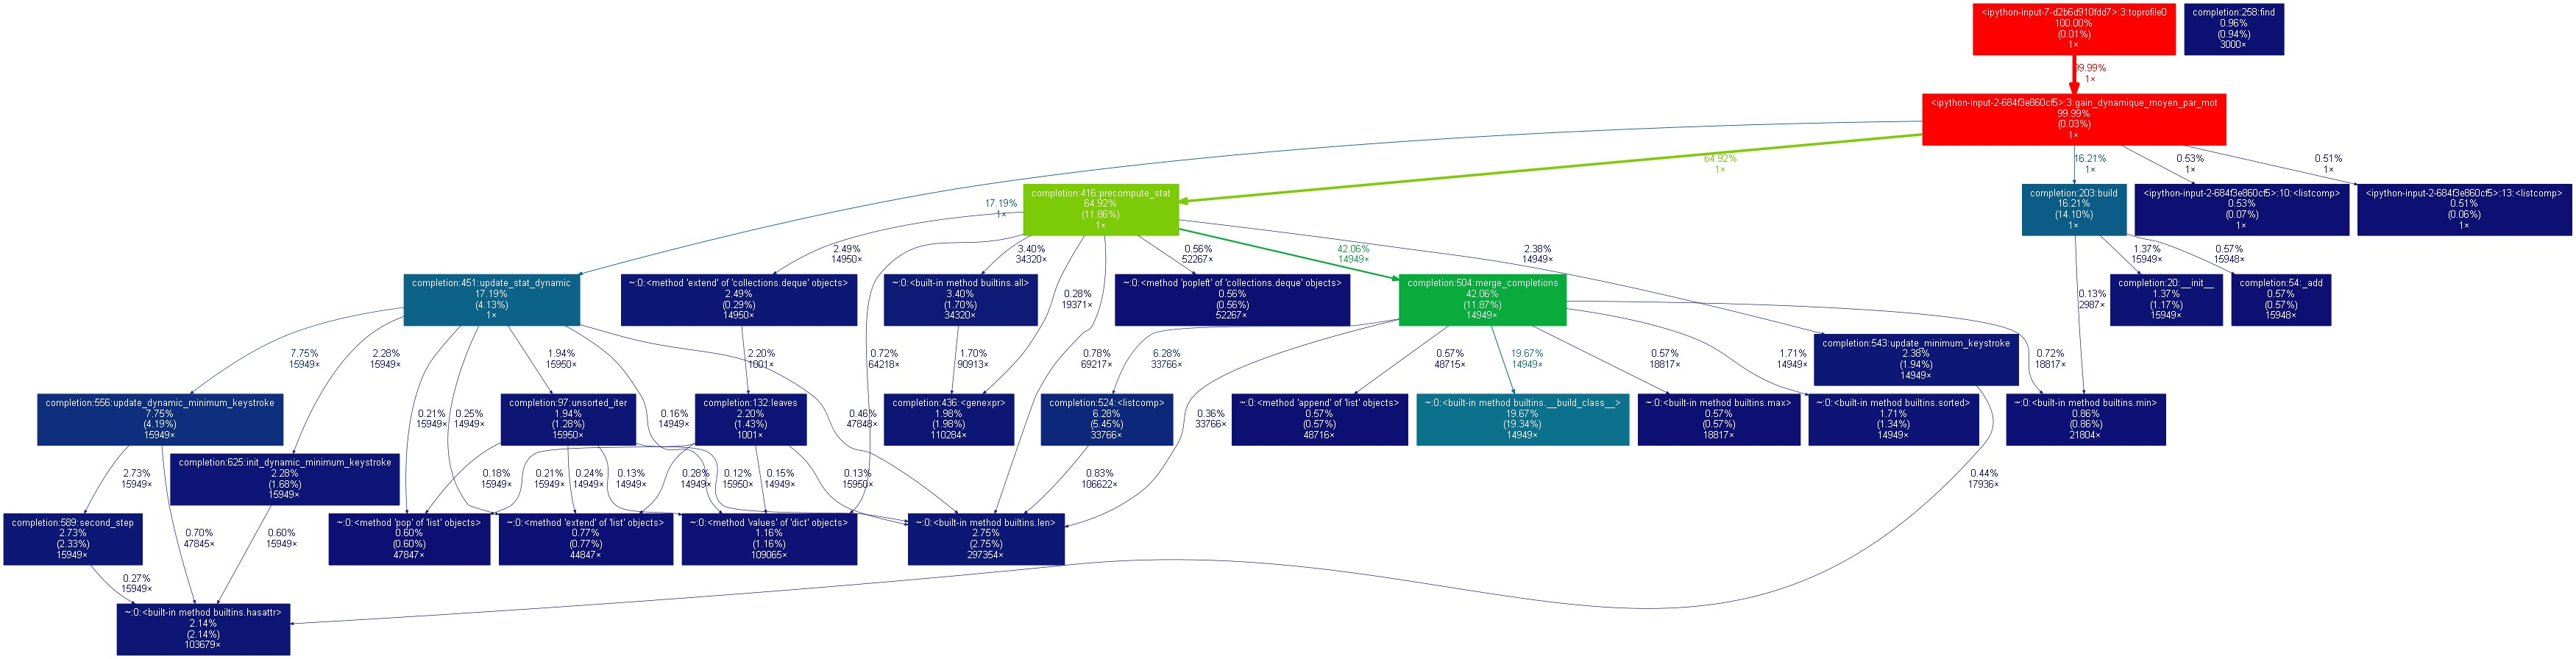

In [21]:
from pyquickhelper.helpgen import NbImage
name = "completion.png"
if os.path.exists("images/completion.jpg"):
    name = "images/completion.jpg"
NbImage(name, width=800)

### pyinstrument

See [pyinstrument](https://github.com/joerick/pyinstrument).

In [22]:
from pyinstrument import Profiler

profiler = Profiler(use_signal=False)
profiler.start()

toprofile0(sample1000)

profiler.stop()
out = profiler.output_text(unicode=False, color=False)
print(out.replace("\\", "/"))

__main__:3: DeprecationWarning: use_signal is deprecated and should no longer be used.


1.414 gain_dynamique_moyen_par_mot  <ipython-input-3-684f3e860cf5>:3
|- 1.050 precompute_stat  mlstatpy/nlp/completion.py:416
|  |- 0.846 merge_completions  mlstatpy/nlp/completion.py:504
|  |  `- 0.071 <listcomp>  mlstatpy/nlp/completion.py:524
|  |- 0.027 <genexpr>  mlstatpy/nlp/completion.py:436
|  |- 0.026 leaves  mlstatpy/nlp/completion.py:132
|  `- 0.015 update_minimum_keystroke  mlstatpy/nlp/completion.py:543
|- 0.235 update_stat_dynamic  mlstatpy/nlp/completion.py:451
|  |- 0.119 update_dynamic_minimum_keystroke  mlstatpy/nlp/completion.py:556
|  |  `- 0.037 second_step  mlstatpy/nlp/completion.py:589
|  |- 0.041 init_dynamic_minimum_keystroke  mlstatpy/nlp/completion.py:625
|  `- 0.020 unsorted_iter  mlstatpy/nlp/completion.py:97
`- 0.096 build  mlstatpy/nlp/completion.py:203
   `- 0.019 __init__  mlstatpy/nlp/completion.py:20



## Javascript Visualization

### SnakeViz

In [23]:
%load_ext snakeviz

L'instruction qui suit lance l'explorateur par défaut avec les données du profilage.

In [24]:
# %snakeviz toprofile0(sample1000)

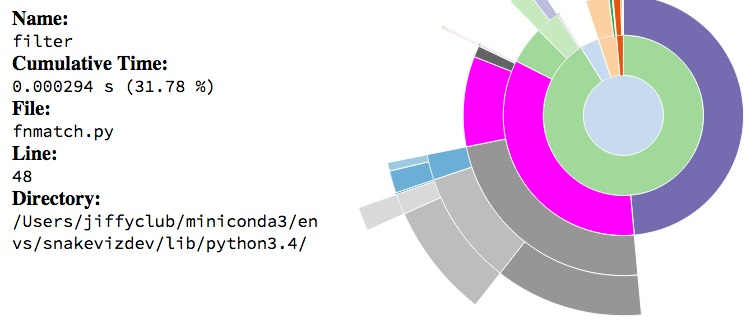

In [25]:
from pyquickhelper.helpgen import NbImage
NbImage("images/func_info.jpg", width=400)

### vprof

See [vprof](https://github.com/nvdv/vprof).

In [26]:
from vprof import profiler

# needs to be run from a file not from a notebook
# profiler.run(toprofile0, 'cmh', args=(sample1000,), host='localhost', port=8000)

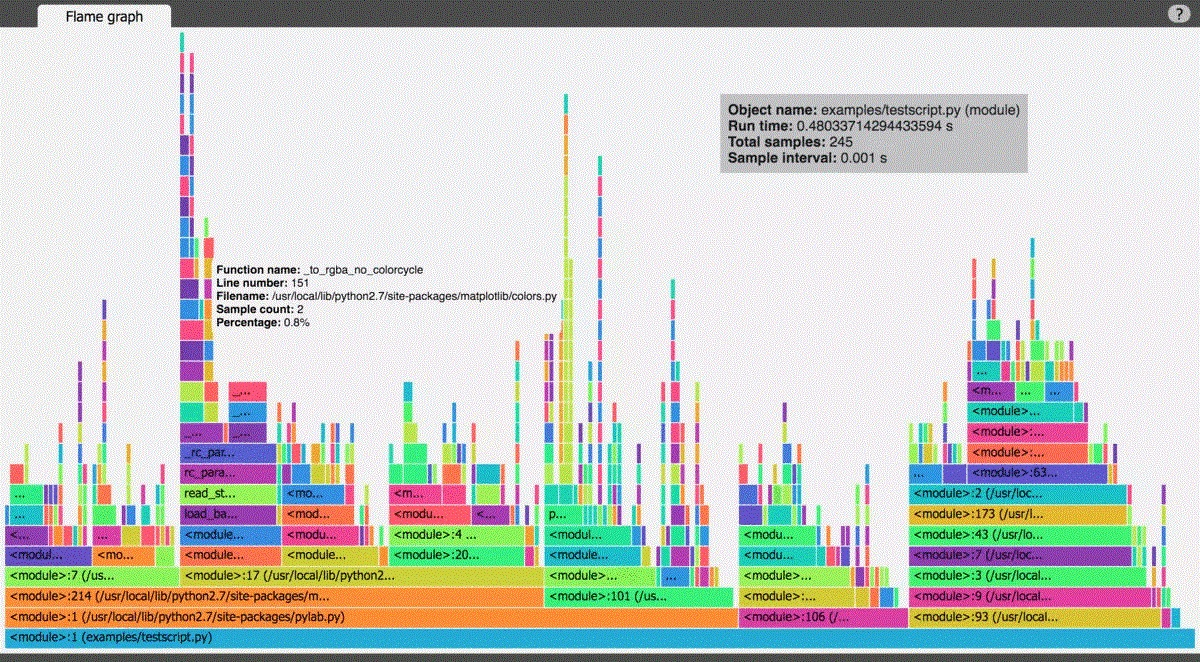

In [27]:
from pyquickhelper.helpgen import NbImage
NbImage("images/vprof.jpg", width=800)